In [3]:
from evcouplings.couplings import CouplingsModel
import pandas as pd
from evcouplings.mutate import predict_mutation_table, single_mutant_matrix
import numpy as np

# Import necessary modules
#import cuml
import bokeh.plotting
import bokeh.io
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#from sklearn.metrics import r2_score, ndcg_score
from scipy.stats import spearmanr
bokeh.io.output_notebook()


Loading BokehJS ...

In [4]:
font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

### Load in the outputs from EVseq

In [82]:
df = pd.read_csv('tm9D8_DSM.csv', index_col=0)
df = df.drop(columns=['VariantCombo','VariantsFound','WellSeqDepth','VariantSequence','IndexPlate','Plate','Well'])
final = df[df['Timepoint'] == 1]
final

,SimpleCombo,AlignmentFrequency,Flags,Timepoint,118 AA,184 AA,EnrichmentRatio,NormEnrich
410,VV,0.043461,NaN,1.0,V,V,4.989688,3.296788
411,VY,0.005312,NaN,1.0,V,Y,1.028012,0.679228
412,YV,0.002265,NaN,1.0,Y,V,0.586929,0.387796
413,YY,0.000396,NaN,1.0,Y,Y,0.177445,0.117241
414,VW,0.006133,NaN,1.0,V,W,1.694445,1.119554
...,...,...,...,...,...,...,...,...
806,AC,0.005548,NaN,1.0,A,C,2.169958,1.433735
807,AD,0.001472,NaN,1.0,A,D,1.038769,0.686335
808,AN,0.003133,NaN,1.0,A,N,1.582767,1.045766
809,AR,0.000811,NaN,1.0,A,R,0.588651,0.388933


### Generate the mutations for EVMutation inputs

In [83]:
WTs = ['A', 'F']
sites = [118, 184]
all_mutations = []
for index, row in final.iterrows():
    mutations = []
    for i, residue in enumerate([row['118 AA'], row['184 AA']]):
        if residue != WTs[i]:
            mutations.append((sites[i], WTs[i], residue))
    all_mutations.append(mutations)
final['Mutations'] = all_mutations

/home/jyang4/miniconda3/envs/mlde2/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Load in the EVcouplings model and predict the EVMutation scores

In [84]:
model = CouplingsModel('tm9D8.model_params')
#model.index_map.items()
#model.index_list
model.seq(118)

'A'

In [85]:
def mut2effect(mutations):
    dE, _, _ = model.delta_hamiltonian(mutations)
    return dE

In [86]:
final['EVMutation'] = final['Mutations'].apply(mut2effect)
final['EVMutation Rank'] = final['EVMutation'].rank(ascending = False)
final['Fitness'] = final['NormEnrich']

/home/jyang4/miniconda3/envs/mlde2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jyang4/miniconda3/envs/mlde2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jyang4/miniconda3/envs/mlde2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

### Load in the Triad outputs and process it

In [87]:
def load_input(triad_output_file):
    #Load fitness data and generate a combo to fitness dict
    fitness_df = final
    combo_to_fitness = {row["SimpleCombo"]: row["Fitness"] for _, row in fitness_df.iterrows()}
    
    # Load the output file
    with open(triad_output_file) as f:

        # Set some flags for starting analysis
        solutions_started = False
        record_start = False

        # Begin looping over the file
        summary_lines = []
        for line in f:

            # Start looking at data once we hit "solution"
            if "Solution" in line:
                solutions_started = True

            # Once we have "Index" we can start recording the rest
            if solutions_started and "Index" in line:
                record_start = True

            # Record appropriate data
            if record_start:

                # Strip the newline and split on whitespace
                summary_line = line.strip().split()

                # If we have hit "Average" stop the whole look
                if summary_line[0] == "Average":
                    break

                # Otherwise, append the line
                summary_lines.append(summary_line)

    # Build the dataframe
    all_results = pd.DataFrame(summary_lines[1:], columns = summary_lines[0])
    all_results["Triad Score"] = all_results.Score.astype(float)
    
    wt_chars = "AF"
    reconstructed_combos = ["".join([char if char != "-" else wt_chars[i] for i, char in enumerate(seq)])
                            for seq in all_results.Seq.values]
    all_results["Combo"] = reconstructed_combos

    # Attach fitness
    all_results["Fitness"] = all_results.Combo.map(combo_to_fitness)
    #all_results["Fitness"] = all_results.Fitness.values / all_results.Fitness.values.max()
    all_results.loc[all_results['Muts'] == 'WT', 'Fitness'] = 1
    all_results = all_results[all_results['Fitness'].notna()]
    # Get the order
    all_results["Triad Rank"] = np.arange(1, len(all_results) + 1)
    
    # Split aas into different columns
    #all_results[["AA1", "AA2", "AA3", "AA4"]] = all_results.Combo.apply(lambda x: pd.Series(list(x)))
    
    return all_results

In [88]:
triad = load_input('Tm9D8_AF_fixed.txt')
triad

,Index,Tags,Score,Seq,Muts,Triad Score,Combo,Fitness,Triad Rank
0,0,"A_184W,17",-1471.53123,-W,A_184W,-1471.53123,AW,0.645273,1
1,1,WT,-1471.13543,--,WT,-1471.13543,AF,1.000000,2
2,2,"A_184H,9",-1471.06707,-H,A_184H,-1471.06707,AH,0.517480,3
3,3,"A_184L,11",-1470.83509,-L,A_184L,-1470.83509,AL,1.808882,4
4,4,"A_184M,13",-1470.04073,-M,A_184M,-1470.04073,AM,1.710988,5
...,...,...,...,...,...,...,...,...,...
395,395,"A_118F+A_184P,274",-1445.55509,FP,A_118F+A_184P,-1445.55509,FP,0.154686,395
396,396,"A_118K+A_184P,234",-1444.87066,KP,A_118K+A_184P,-1444.87066,KP,0.102616,396
397,397,"A_118P+A_184P,294",-1444.66566,PP,A_118P+A_184P,-1444.66566,PP,0.187469,397
398,398,"A_118Y+A_184P,374",-1443.00514,YP,A_118Y+A_184P,-1443.00514,YP,0.111456,398


In [89]:
combined = final.merge(triad[['Combo', 'Muts', 'Triad Score', 'Triad Rank']], left_on='SimpleCombo', right_on='Combo')
combined

,SimpleCombo,AlignmentFrequency,Flags,Timepoint,118 AA,184 AA,EnrichmentRatio,NormEnrich,Mutations,EVMutation,EVMutation Rank,Fitness,Combo,Muts,Triad Score,Triad Rank
0,VV,0.043461,NaN,1.0,V,V,4.989688,3.296788,"[(118, A, V), (184, F, V)]",-0.623120,8.0,3.296788,VV,A_118V+A_184V,-1466.17865,52
1,VY,0.005312,NaN,1.0,V,Y,1.028012,0.679228,"[(118, A, V), (184, F, Y)]",-6.341434,67.0,0.679228,VY,A_118V+A_184Y,-1465.89934,59
2,YV,0.002265,NaN,1.0,Y,V,0.586929,0.387796,"[(118, A, Y), (184, F, V)]",-9.419829,126.5,0.387796,YV,A_118Y+A_184V,-1453.35054,339
3,YY,0.000396,NaN,1.0,Y,Y,0.177445,0.117241,"[(118, A, Y), (184, F, Y)]",-15.231036,347.5,0.117241,YY,A_118Y+A_184Y,-1453.07123,344
4,VW,0.006133,NaN,1.0,V,W,1.694445,1.119554,"[(118, A, V), (184, F, W)]",-6.534317,72.0,1.119554,VW,A_118V+A_184W,-1468.52555,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,AC,0.005548,NaN,1.0,A,C,2.169958,1.433735,"[(184, F, C)]",-3.629406,19.0,1.433735,AC,A_184C,-1468.03410,23
395,AD,0.001472,NaN,1.0,A,D,1.038769,0.686335,"[(184, F, D)]",-4.201387,26.0,0.686335,AD,A_184D,-1466.44085,41
396,AN,0.003133,NaN,1.0,A,N,1.582767,1.045766,"[(184, F, N)]",-4.826133,32.0,1.045766,AN,A_184N,-1468.30286,17
397,AR,0.000811,NaN,1.0,A,R,0.588651,0.388933,"[(184, F, R)]",-4.770421,31.0,0.388933,AR,A_184R,-1466.57515,38


In [93]:
def plot_correlation(all_results, column):
    #ax.get_xaxis().set_visible(False)
    #print(r2_score(all_results['Score'], all_results['Fitness']))
    #plt.text(110, 1.5, 'NDCG = ' + str(round(ndcg_score([all_results.Fitness.values], [all_results.Order.values]),3)))
    print()
    plt.title(column)
    plt.text(300, 3, '\u03C1 = ' + str(round(spearmanr(-1*all_results[column], all_results['Fitness'])[0],3)))
    plt.plot(all_results[column].values, all_results['Fitness'].values, '.', markersize = 5)
    plt.plot(all_results.loc[all_results['Muts'] == 'WT', column], all_results.loc[all_results['Muts'] == 'WT', 'Fitness'], '.', markersize = 10)
    plt.xlabel('Ranking')
    plt.ylabel('Fitness')
    plt.legend(['Variants', 'WT'])

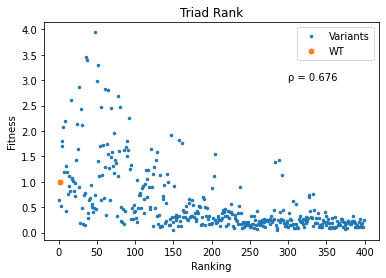

In [94]:
plot_correlation(combined, 'Triad Rank')

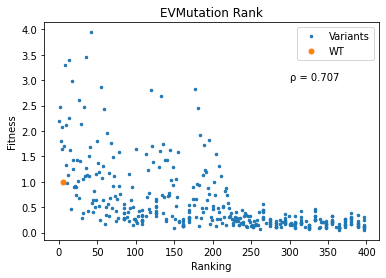

In [95]:
plot_correlation(combined, 'EVMutation Rank')